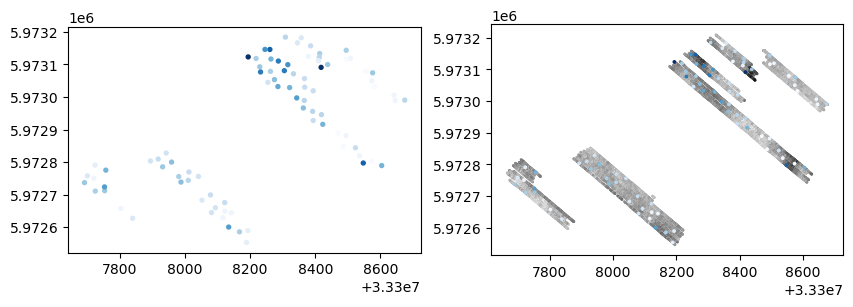

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the predicted_points.geojson
gdf = gpd.read_file("soil_scanning_predicted_points.geojson")

# Read the lab data
gdf_lab = gpd.read_file("Lab_data/Kassow_lab_data_2022_F1_F2_F3.geojson")

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

im1 = gdf_lab.plot(ax=axs[0], column='P', cmap='Blues', aspect=1, markersize=8)

im1 =     gdf.plot(ax=axs[1], column='P', cmap='Grays', aspect=1, markersize=1)
im1 = gdf_lab.plot(ax=axs[1], column='P', cmap='Blues', aspect=1, markersize=3)

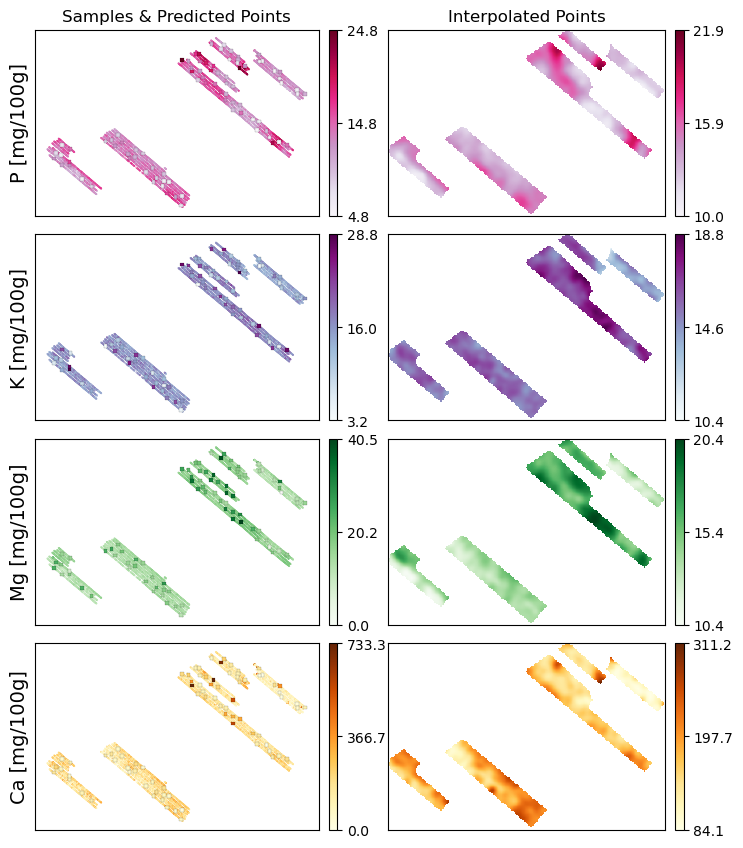

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as mcb

import geopandas as gpd
import rasterio
from skimage.transform import resize
import scipy.ndimage
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read the predicted_points.geojson
gdf = gpd.read_file("soil_scanning_predicted_points.geojson")

# Read the lab data
gdf_lab = gpd.read_file("Lab_data/Kassow_lab_data_2022_F1_F2_F3.geojson")

part = 2
if part == 1:
    layers = ["IDW_P.tif", "IDW_K.tif", "IDW_Mg.tif", "IDW_Ca.tif", "IDW_TOC.tif", "IDW_CEC.tif", "IDW_pH.tif", "IDW_MC.tif", "IDW_Clay.tif"]
    labels = ["P [mg/100g]", "K [mg/100g]", "Mg [mg/100g]", "Ca [mg/100g]", "TOC [%]", "CEC [cmol/kg]", "pH", "MC [%]", "clay [%]"]
    cmaps = ['PuRd',       'BuPu',        'Greens',       'GnBu',         'Greys',  'plasma',      'gist_rainbow', 'Blues', 'YlOrBr']

if part == 2:
    gdf.drop(columns=['TOC', 'CEC', 'pH', 'MC', 'Clay'], inplace=True)
    gdf_lab.drop(columns=['TOC', 'CEC', 'pH', 'MC', 'Clay'], inplace=True)
    layers = ["IDW_P.tif", "IDW_K.tif", "IDW_Mg.tif", "IDW_Ca.tif"]
    labels = ["P [mg/100g]", "K [mg/100g]", "Mg [mg/100g]", "Ca [mg/100g]"]
    cmaps = ['PuRd',       'BuPu',        'Greens',       'YlOrBr']

if part == 3:
    gdf.drop(columns=['P', 'K', 'Mg', 'Ca'], inplace=True)
    gdf_lab.drop(columns=['P', 'K', 'Mg', 'Ca'], inplace=True)
    layers = ["IDW_TOC.tif", "IDW_CEC.tif", "IDW_pH.tif", "IDW_MC.tif", "IDW_Clay.tif"]
    labels = ["TOC [%]", "CEC [cmol/kg]", "pH", "MC [%]", "clay [%]"]
    cmaps = ['Greys',  'plasma',      'Spectral', 'Blues', 'YlOrBr']

# Plot the results in a single large plot 15*cm, 5*cm
fig, axs = plt.subplots(nrows=len(layers), ncols=2, figsize=(7, 2 * len(layers)))

# Loop through layers
for i, layer in enumerate(layers):
    #print(i)
    input_path = f"IDW/{layer}"
    mask_path = "soil_scanning_boundaries_F1_F2_F3.tif"
    with rasterio.open(input_path) as src_idw, rasterio.open(mask_path) as src_mask:
        idw_image = src_idw.read(1)
        mask_image = src_mask.read(1)
        transform = src_idw.transform
        crs = src_idw.crs  # Use CRS from the original IDW image

    # Apply Gaussian filter for smoothing
    smoothed_image = scipy.ndimage.gaussian_filter(idw_image, sigma=2)

    # Resize the mask image to match the shape of the smoothed image
    resized_mask = resize(mask_image, smoothed_image.shape, mode='constant', anti_aliasing=True)

    # Mask the original layer everywhere, where more than 50% of the underlying pixels are 0
    masked_original_image = np.where(resized_mask > 0.5, idw_image, np.NaN)

    # Mask the smoothed layer everywhere, where more than 50% of the underlying pixels are 0
    masked_smoothed_image = np.where(resized_mask > 0.5, smoothed_image, np.NaN)

    # Save the smoothed image as GeoTIFF
    output_path_smoothed = f"IDW_smoothed/IDW_smoothed_{layer}"
    with rasterio.open(output_path_smoothed, 'w', driver='GTiff', height=idw_image.shape[0], width=idw_image.shape[1], count=1,
                       dtype=idw_image.dtype, crs=crs, transform=transform) as dst:
        dst.write(smoothed_image, 1)

    # Save the masked and smoothed image as GeoTIFF
    output_path_masked = f"IDW_smoothed_masked/IDW_smoothed_masked_{layer}"
    with rasterio.open(output_path_masked, 'w', driver='GTiff', height=idw_image.shape[0], width=idw_image.shape[1],
                       count=1, dtype=idw_image.dtype, crs=crs, transform=transform, nodata=np.NaN) as dst:
        dst.write(masked_smoothed_image, 1)

    # The the min and max values of the predicted points (for the plots)
    vmin_pred = gdf.iloc[:,i].min()
    vmax_pred = gdf.iloc[:,i].max()
    vmax_idw  = np.nanmax(masked_smoothed_image)
    vmin_idw  = np.nanmin(masked_smoothed_image)

    # Plot Predicted Points using GeoDataFrame
    if not layer == 'IDW_pH.tif':
        gdf.plot(column=gdf.iloc[:,i], aspect=1, markersize=0.1, cmap=cmaps[i], vmin=vmin_pred, vmax=vmax_pred, ax=axs[i, 0])
        gdf_lab.plot(column=gdf_lab.iloc[:,i],aspect=1, markersize=7, marker="s", edgecolor="black", linewidth=0.1, cmap=cmaps[i], ax=axs[i, 0])
    else:
        gdf.plot(column=gdf.iloc[:,i], aspect=1, markersize=0.1, cmap=cmaps[i], vmin=6, vmax=8, ax=axs[i, 0])
        gdf_lab.plot(column=gdf_lab.iloc[:,i],aspect=1, markersize=7, marker="s", edgecolor="black", linewidth=0.1, cmap=cmaps[i], ax=axs[i, 0])
        #print(gdf_lab.iloc[:,i])
    if i==0:
        axs[i, 0].set_title('Samples & Predicted Points')
    
    axs[i, 0].set_ylabel(labels[i], fontsize=14)
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])

    # Plott IDW with Gaussian filter
    if not layer == 'IDW_pH.tif':
        axs[i, 1].imshow(masked_smoothed_image, cmap=cmaps[i], vmin=vmin_idw, vmax=vmax_idw)
    else:
        axs[i, 1].imshow(masked_smoothed_image, cmap=cmaps[i], vmin=6, vmax=8)
    if i==0:
        axs[i, 1].set_title('Interpolated Points')
    #axs[i, 1].axis('off')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])

    # Create a colorbar for the first subplot
    divider = make_axes_locatable(axs[i, 0])
    cax = divider.append_axes("right", size="3%", pad=0.1)
    if not layer == 'IDW_pH.tif':
        cbar = mcb.ColorbarBase(cax, cmap=cmaps[i], norm=plt.Normalize(vmin_pred, vmax_pred))
        cbar.set_ticks([vmin_pred, (vmax_pred-vmin_pred)*0.5+vmin_pred, vmax_pred])
        cbar.set_ticklabels([f'{vmin_pred:.1f}', f'{((vmax_pred-vmin_pred)*0.5+vmin_pred):.1f}', f'{vmax_pred:.1f}'])  # Format ticks with one digit after zero
    else:
        cbar = mcb.ColorbarBase(cax, cmap=cmaps[i], norm=plt.Normalize(5, 9))
        cbar.set_ticks([6,7,8])
        
    # Create a common colorbar for the second subplot
    divider = make_axes_locatable(axs[i, 1])
    cax = divider.append_axes("right", size="3%", pad=0.1)
    if not layer == 'IDW_pH.tif':
        cbar = mcb.ColorbarBase(cax, cmap=cmaps[i], norm=plt.Normalize(vmin_idw, vmax_idw))
        cbar.set_ticks([vmin_idw, ((vmax_idw-vmin_idw)*0.5+vmin_idw), vmax_idw])
        cbar.set_ticklabels([f'{vmin_idw:.1f}', f'{((vmax_idw-vmin_idw)*0.5+vmin_idw):.1f}', f'{vmax_idw:.1f}'])  # Format ticks with one digit after zero
    else:
        cbar = mcb.ColorbarBase(cax, cmap=cmaps[i], norm=plt.Normalize(5, 9))
        cbar.set_ticks([6,7,8])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,wspace=0, hspace=0.1)

plt.savefig("plots/IDW_{}.png".format(part), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
## Calculate z-scores for a GeoDataFrame
gdf = gpd.read_file("soil_scanning_predicted_points.geojson")

# Assuming your GeoDataFrame is named 'gdf'
columns_to_normalize = ['P', 'K', 'Mg', 'Ca', 'TOC', 'CEC', 'pH', 'MC', 'Clay', 'altitude']

# Calculate z-scores
z_scores = zscore(gdf[columns_to_normalize])

# Create a new GeoDataFrame with the z-scores
z_scores_gdf = gdf.copy()
z_scores_gdf[columns_to_normalize] = z_scores

print("Transform crs of Stenon_sampled_Soil_Scanning.geojson from",old_crs,"to",new_crs)

# Save GeoDataFrame to GeoJSON
z_scores_gdf.to_file('soil_scanning_z-values.geojson', driver='GeoJSON')

In [3]:
# Use the Gauss filter on the Z-Values
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as mcb

import geopandas as gpd
import rasterio
from skimage.transform import resize
import scipy.ndimage
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read the predicted_points.geojson
gdf = gpd.read_file("soil_scanning_z-values.geojson")

layers = ["IDW_P_z.tif", "IDW_K_z.tif", "IDW_Mg_z.tif", "IDW_Ca_z.tif", "IDW_TOC_z.tif", "IDW_CEC_z.tif", "IDW_pH_z.tif", "IDW_MC_z.tif", "IDW_Clay_z.tif"]

# Loop through layers
for i, layer in enumerate(layers):
    #print(i)
    input_path = f"IDW/{layer}"
    mask_path = "soil_scanning_boundaries_F1_F2_F3.tif"
    with rasterio.open(input_path) as src_idw, rasterio.open(mask_path) as src_mask:
        idw_image = src_idw.read(1)
        mask_image = src_mask.read(1)
        transform = src_idw.transform
        crs = src_idw.crs  # Use CRS from the original IDW image

    # Apply Gaussian filter for smoothing
    smoothed_image = scipy.ndimage.gaussian_filter(idw_image, sigma=2)

    # Resize the mask image to match the shape of the smoothed image
    resized_mask = resize(mask_image, smoothed_image.shape, mode='constant', anti_aliasing=True)

    # Mask the original layer everywhere, where more than 50% of the underlying pixels are 0
    masked_original_image = np.where(resized_mask > 0.5, idw_image, np.NaN)

    # Mask the smoothed layer everywhere, where more than 50% of the underlying pixels are 0
    masked_smoothed_image = np.where(resized_mask > 0.5, smoothed_image, np.NaN)

    # Save the smoothed image as GeoTIFF
    output_path_smoothed = f"IDW_smoothed/IDW_smoothed_{layer}"
    with rasterio.open(output_path_smoothed, 'w', driver='GTiff', height=idw_image.shape[0], width=idw_image.shape[1], count=1,
                       dtype=idw_image.dtype, crs=crs, transform=transform) as dst:
        dst.write(smoothed_image, 1)

    # Save the masked and smoothed image as GeoTIFF
    output_path_masked = f"IDW_smoothed_masked/IDW_smoothed_masked_{layer}"
    with rasterio.open(output_path_masked, 'w', driver='GTiff', height=idw_image.shape[0], width=idw_image.shape[1],
                       count=1, dtype=idw_image.dtype, crs=crs, transform=transform, nodata=np.NaN) as dst:
        dst.write(masked_smoothed_image, 1)
